### Accompanying code and data for the manuscript:


## "A Mechanism for Ovulation Number Control"

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.integrate import ode
from scipy import stats
import warnings
import pickle as pkl


### Dominant follicle linear growth data 
Adapted from Figure 3A and 3B in the paper:

>A. R. Baerwald, G. P. Adams, and R. A. Pierson, [“A new model for ovarian follicular development during the human menstrual cycle”](https://pubmed.ncbi.nlm.nih.gov/12849812/), Fertility and Sterility, vol. 80, no. 1, pp. 116–122, Jul. 2003, doi: 10.1016/S0015-0282(03)00544-2

Data was digitizeed from the image. We used data of the ovulatory waves of two-wave women (presesnted in Figure 1D of our manuscript) and three-wave women (presented in Figure S1).
A regression line was fitted for the diameter of the dominant follicle, from the first data point until the day before the last day of the follicular phase, since Estradiol control changes sign in the last day of the phase from negative to positive. 

#### Diameter of dominant folicle in the ovulatory wave of women with two follicular waves wave 

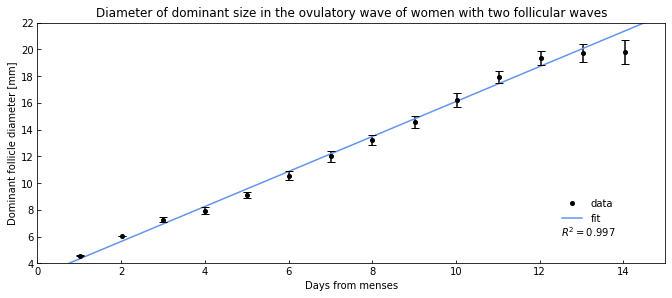

Regression line: y=1.31x+-14.0
Standard error of the slope: 0.03


In [10]:
#loading data
with open('Data/2wavesdominant.csv') as file1: 
    dominant_2waves = pd.read_csv(file1)

with open('Data/2waves_errorbars.csv') as file2: 
    dominant_2waves_errobars = pd.read_csv(file2)
dominant_2waves_errobars['errors'] = dominant_2waves_errobars.error_bar_height-dominant_2waves.diameter

#linear regression
slope, intercept, r, p, se = stats.linregress(dominant_2waves['t'][:13], dominant_2waves['diameter'][:13])
fit_line = slope*np.arange(11, 29, 1)+intercept

#plotting
plt.rcParams["figure.figsize"] = (1.5*2.5*3,1.5*2.5*1.18)
handle_fit,  = plt.plot(np.arange(11, 29, 1)-13, fit_line, label='fit', color='cornflowerblue')
plt.errorbar(dominant_2waves['t']-13, dominant_2waves['diameter'],
                             yerr = dominant_2waves_errobars.errors, linestyle='None',
                                marker='None', capsize=4, capthick=1, color='black')
handle_data,  = plt.plot(dominant_2waves['t']-13, dominant_2waves['diameter'],'ko', label='data', markersize=4)
plt.tick_params(direction='in')
plt.yticks(np.arange(2, 24, 2))
plt.ylim([4, 22])
plt.xlim([0, 15])
plt.text(12.5, 6, f'$R^2={round(r, 3)}$')
plt.title("Diameter of dominant size in the ovulatory wave of women with two follicular waves")
plt.legend(handles=[handle_data, handle_fit], loc = [0.83,0.15], frameon=False)
plt.xlabel('Days from menses')
plt.ylabel('Dominant follicle diameter [mm]')
plt.show()
print(f'Regression line: y={round(slope, 2)}x+{round(intercept, 2)}')
print(f'Standard error of the slope: {round(se,2)}')

#### Diameter of dominant folicle in the ovulatory wave of women with three follicular waves wave 


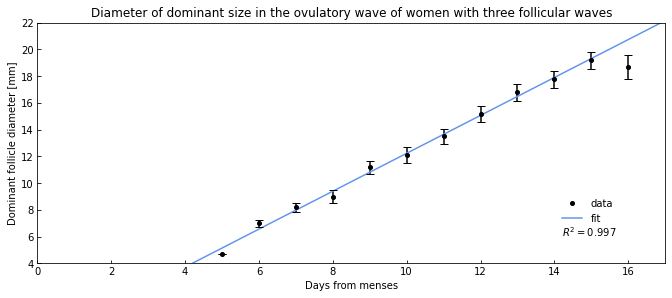

Regression line: y=1.31x+-14.0
Standard error of the slope: 0.03


In [11]:
#loading data
with open('Data/3wavesdominant.csv') as file1: 
    dominant_3waves = pd.read_csv(file1)
with open('Data/3waves_errorbars.csv') as file2: 
    dominant_3waves_errobars = pd.read_csv(file2)
dominant_3waves['t'] = np.arange(18,30,1)
dominant_3waves_errobars['t'] = np.arange(18,30,1)
dominant_3waves_errobars['errors'] = dominant_3waves_errobars.error_bar_height-dominant_3waves.diameter

#linear regression
slope3, intercept3, r3, p3, se3 = stats.linregress(dominant_3waves['t'][:-1], dominant_3waves['diameter'][:-1])
fit_line3 = slope3*np.arange(11, 31, 1)+intercept3

#plotting
plt.rcParams["figure.figsize"] = (1.5*2.5*3,1.5*2.5*1.18)
handle_fit,  = plt.plot(np.arange(11, 31, 1)-13, fit_line3, label='fit', color='cornflowerblue')
plt.errorbar(dominant_3waves['t']-13, dominant_3waves['diameter'],
                             yerr = dominant_3waves_errobars.errors, linestyle='None',
                                marker='None', capsize=4, capthick=1, color='black')
handle_data,  = plt.plot(dominant_3waves['t']-13, dominant_3waves['diameter'],'ko', label='data', markersize=4)
plt.tick_params(direction='in')
plt.yticks(np.arange(2, 24, 2))
plt.ylim([4, 22])
plt.xlim([0, 17])
plt.text(14.2, 6, f'$R^2={round(r, 3)}$')
plt.title("Diameter of dominant size in the ovulatory wave of women with three follicular waves")
plt.legend(handles=[handle_data, handle_fit], loc = [0.83,0.15], frameon=False)
plt.xlabel('Days from menses')
plt.ylabel('Dominant follicle diameter [mm]')
plt.show()

print(f'Regression line: y={round(slope, 2)}x+{round(intercept, 2)}')
print(f'Standard error of the slope: {round(se,2)}')

### Numeric simulation of follicular growth
Simulations using this code were presented in Figure 2 C,D,E,F, and Figure S4)


In [10]:
def dparabola_dt(t, y, M1, M2, a_ex, C, mean):
    """
    Defines the differential equations to be simulated
    
    Parameters:
    t (float): time (required for scipy.integrate.ode solver)
    y (np.array): follicle sizes
    M1 (float): biphasic effect parameter
    M2 (float): biphasic effect parameter
    a_ex (float): external androgen (can be used to simulate hyperandrogenic states)
    C (float): timescale parameter
    
    Returns:
    dy : the rate of growth of the follicles (right-hand size of the differential equations)
    
    """
    total_size = sum(y) # this is what we call x_T in the paper
    a = y/total_size    # androgen~realtive size
    dy = -C*a*(1 - M1*(a+a_ex))*(1 - M2*(a+a_ex)) #change in follicles size
    return dy

In [12]:
def plot_follicles(sizes_df, androgen_df, M1, M2, ovulations, a_ex, x_limits = 0, y_limits = 0):
    """
    Plots the sizes and relative sizes of the follicles throughout the simulation.

    Parameters:
    sizes_df(pandas.DataFrame): A data frame containing the time points of the simulation (column 't') and the 
                                sizes of the follicles throughout the simulation (columns '1','2',...,'n' for
                                n follicels). Each row represents one timepoint in the simulation. 
    androgen_df(pandas.DataFrame): A data frame containing the time points of the simulation (column 't') and the 
                                relative sizes of the follicles (~follicular androgen) throughout the simulation 
                                (columns '1','2',...,'n' for n follicels). Each row represents one timepoint in 
                                the simulation. 
    M1 (float): biphasic effect parameter
    M2 (float): biphasic effect parameter
    ovulations (int): number of follicles who ovulated, counted by count_ovulations()
    a_ex (float): external androgen
    x_limits(tuple of floats): for plotting purposes -(lower limit of the x axis, upper limit of the x axis) 
    y_limits: for plotting purposes -(lower limit of the y axis, upper limit of the y axis) 
    
    """
    fig, axes = plt.subplots(2, 1)
    M_star = 2*M1*M2/(M1+M2)
    handle1, = axes[1].plot(sizes_df.t, np.ones(len(sizes_df.t))/M1, color = 'silver', linestyle = '--', label = '1/M1')
    handle2, = axes[1].plot(sizes_df.t, np.ones(len(sizes_df.t))/M_star, color = 'silver', linestyle = '-.', label = '1/M*')
    handle3, = axes[1].plot(sizes_df.t, np.ones(len(sizes_df.t))/(0.5*M_star), color = 'silver', linestyle ='-', label = '2/M*')
    handle4, = axes[1].plot(sizes_df.t, np.ones(len(sizes_df.t))/M2, color = 'silver', linestyle = ':', label= '1/M2')
    sizes_df.plot(x = 't', figsize=(10,13), ax = axes[0], legend =False)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        androgen_df.plot(x = 't', figsize=(10,13), ax = axes[1], label='_bl', legend = True)
        axes[1].legend(handles=[handle1, handle2, handle3, handle4])
    axes[1].set_xlabel('t')
    axes[0].set_xlabel('t')
    axes[0].set_ylabel('follicle size')
    axes[1].set_ylabel('androgens (x/x_T)')
    for ax in axes:
        if x_limits:
            ax.set_xlim(x_limits)
        else:
            ax.autoscale(enable=True, axis='x', tight=True)
    if y_limits:
        axes[0].set_ylim(y_limits)
    A_text = ''
    if a_ex>0:
        A_text = f', a_ex = {a_ex}'
    axes[0].set_title(f'Follicular Growth for Parabolic Model with M1={M1}, M2={M2},M* = {round(M_star,2)}, {ovulations} ovulations'+A_text)
    plt.show()

In [13]:
def count_ovulations(y, mean, initial_xT):
    """
    Counts the number of follicles who ovulate when the total follicular size reaches the threshold for ovulation.
    This function is not completely accurate in counting ovulations (as the ovulating follicles were arbitrarily
    defined as all follices which are larger than 1.5 of the mean initial size), but it serves mainly to alert 
    that the threshold for ovualtion has been achieved so that the simulation will be stopped.

    Parameters:
    y (np.array [current timepoints in the simulation, number of follicles]): A numpy array containing the sizes of
                    the follicles in each time point in the simulation. 
    mean (float): the mean size of the follicles in the first time point.
    initial_x_T(float): the sum of sizes of the follicles in the first time point (~Estradiol).
    
    Returns: 
    ovulated (int): number of "large" follicles when ovulation threshold is achieved,
                    or zero if ovulation threshold is not achieved
    """
    threshold_passed = y[-1,:].sum()>=4.6*initial_xT
    if threshold_passed:
        large = (y[-1,:]>1.5*mean).sum()
        ovulated = large
    else:
        ovulated = 0
    return ovulated

In [15]:
def simulate_follicles(M1, M2, a_ex, C=1, initial_sizes = np.zeros(5), n=5):
    """
    Numerically simulate the follicular growth during the follicular phase, until ovulation threshold is reached,
    and plots the results.
    
    Parameters:
    M1 (float): biphasic effect parameter
    M2 (float): biphasic effect parameter
    a_ex(float): external androgen (can be used to simulate hyperandrogenic states)
    C (float): timescale parameter
    initial_sizes: initial size of the follicles in t=0. Default np.zeros(5) means the inital sizes
                    will be drawn randomly.
    n = batch size, number of follicles in the simulation
    
    Returns:
    ovulations (int): number of follicles who ovulated, counted by count_ovulations()
    sizes_df(pandas.DataFrame): A data frame containing the time points of the simulation (column 't') and the 
                                sizes of the follicles throughout the simulation (columns '1','2',...,'n' for
                                n follicels). Each row represents one timepoint in the simulation. 
    androgen_df(pandas.DataFrame): A data frame containing the time points of the simulation (column 't') and the 
                                relative sizes of the follicles (~follicular androgen) throughout the simulation 
                                (columns '1','2',...,'n' for n follicels). Each row represents one timepoint in 
                                the simulation. 
    y[0,:] (np.array): initial sizes of the follicles in t=0. 
    """


    # parameters
    samples_per_day = 30
    end_time = 800
    model_fun = dparabola_dt
    M_star = 2*M1*M2/(M1+M2)
    mean = 0.1 #mean initial size of follicles

    #initiation
    t = np.linspace(0,end_time, samples_per_day*end_time)
    dt = t[1] - t[0]    
    y = np.zeros((len(t), n))
    if initial_sizes.any():
        y[0,:] = initial_sizes
    else:
        y[0,:] = mean+(np.random.rand(n)-0.5)/10 #initial follicular sizes drawn from a uniform distribution
    initial_xT=np.sum(y[0,:]) 
    
    #setting the solver and initiating it
    my_solver = ode(model_fun).set_integrator('vode', method='bdf')
    my_solver.set_initial_value(y[0,:], t[0]).set_f_params(M1, M2, a_ex, C, mean)
    ovulations = 0
    i=1
    
    #iterating the solver
    while ((my_solver.successful() and my_solver.t<end_time) and i<len(t)):
        my_solver.integrate(my_solver.t + dt)
        my_solver.y[my_solver.y<0]=0
        y[i,:] = my_solver.y
        ovulations = count_ovulations(y[:i+1,:], mean, initial_xT)
        if ovulations>0: 
            break
            end_time = my_solver.t
        i=i+1
    
    y = y[:i+1,:]
    t = t[:i+1]
    a = y/y.sum(axis = 1).reshape([y.shape[0], 1])
    
    #creating pandas dataframe for the results
    sizes_df = pd.DataFrame(data = np.hstack((t.reshape([-1,1]) , y))).dropna().rename(columns = {0:'t'})
    androgen_df = pd.DataFrame(data = np.hstack((t.reshape([-1,1]) , a))).dropna()
    androgen_df = androgen_df.rename(columns = lambda x:'_'+str(x)).rename(columns = {'_0':'t'})
    plot_follicles(sizes_df, androgen_df, M1, M2, ovulations, a_ex)
    return ovulations, sizes_df, androgen_df, y[0,:]

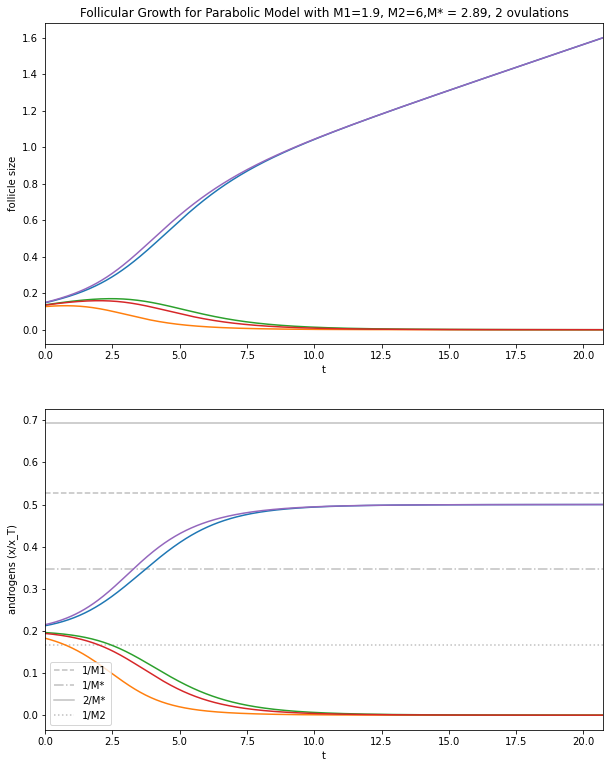

In [22]:
M1 = 1.9
M2 = 6
n = 5
ovulations, sizes_df, androgen_df, init = simulate_follicles(M1=M1 ,M2=M2, n=n, a_ex=0)

### Serum FSH and Estradiol over the follicular phase
Adapted from Figure 1 in the paper:

>R. I. Mclachlan, N. L. Cohen, K. D. Dahl, W. J. Bremner, and M. R. Souls, [“Serum inhibin levels during the periovulatory interval in normal women: relationships with sex steroids and gonadotrophin levels”](https://onlinelibrary.wiley.com/doi/10.1111/j.1365-2265.1990.tb03748.x), Clinical Endocrinology, 1990, doi: 10.1111/j.1365-2265.1990.tb03748.x.

Data was digitizeed from the image. Regression line wasfitted from day -15 to day -2 relative to the LH surge, after which FSH starts to rise fast as a result of change of sign of estradiol control of gonadotropins.Results presented in Figure S2.

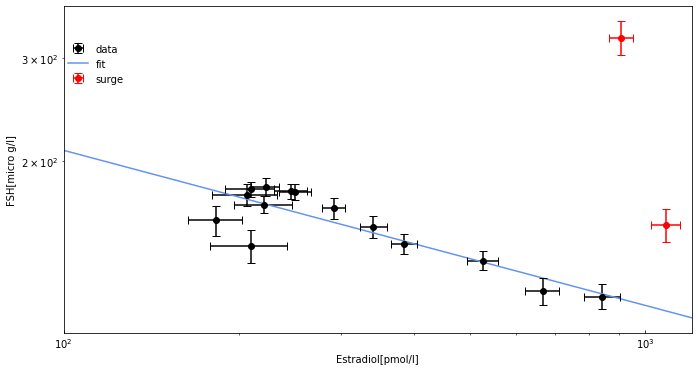

Regression line: y=-0.27x+6.57
Standard error of the slope: 0.04


In [22]:
#load data
with open('Data/FSH.csv') as f: 
    FSH_df = pd.read_csv(f)
with open('Data/E.csv') as f: 
    E_df = pd.read_csv(f)
FSH_df['time'] = pd.Series(np.arange(-15, 16, 1))
E_df['time'] = pd.Series(np.arange(-15, 16, 1))
E_df.E_errors = E_df.E_errors - E_df.E
FSH_df.FSH_errors = FSH_df.FSH_errors - FSH_df.FSH

#linear regression 
begin= 0
end=14
slope, intercept, r, p, se = stats.linregress(np.log(E_df.E[begin:end]), np.log(FSH_df.FSH[begin:end]))
fit_line = slope*np.log(np.arange(100, 1200, 1))+intercept

#plot
plt.rcParams["figure.figsize"] = (1.5*2.5*3,1.5*2.5*1.6)
handle_fit, = plt.plot(np.arange(100,1200,1), np.exp(fit_line), color='cornflowerblue', label = 'fit')
handle_data = plt.errorbar(E_df.E[begin:end], FSH_df.FSH[begin:end],
                             xerr = E_df.E_errors[begin:end], yerr = FSH_df.FSH_errors[begin:end], linestyle='None',
                                marker='o', capsize=4, capthick=1, color='black', label='data')
handle_more_data = plt.errorbar(E_df.E[end:16], FSH_df.FSH[end:16],
                             xerr = E_df.E_errors[end:16], yerr = FSH_df.FSH_errors[end:16], linestyle='None',
                                marker='o', capsize=4, capthick=1, color='red', label='surge')

plt.xlim([100,1200])
plt.yticks(np.arange(100, 400, 20))
plt.xticks(np.arange(200, 1400, 200))
plt.tick_params(direction='in')
plt.yscale('log')
plt.xscale('log')
plt.legend(handles=[handle_data, handle_fit, handle_more_data], loc = [0,0.75], frameon=False)
plt.xlabel('Estradiol[pmol/l]')
plt.ylabel('FSH[micro g/l]')
plt.show()

print(f'Regression line: y={round(slope, 2)}x+{round(intercept, 2)}')
print(f'Standard error of the slope: {round(se,2)}')

Estradiol throught the follicular phase is shown in Figure S3C:

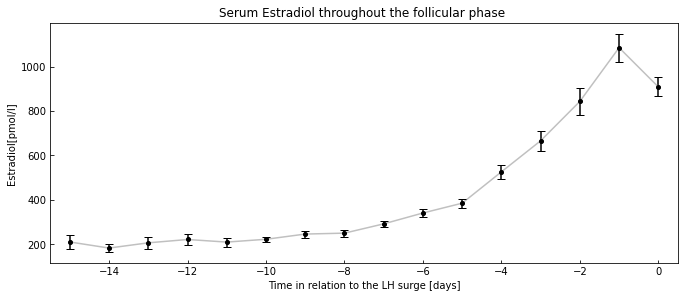

In [26]:
#plot
plt.rcParams["figure.figsize"] = (1.5*2.5*3,1.5*2.5*1.18)
plt.plot(E_df.time[:16], E_df.E[:16], 'silver',E_df.time[:16], E_df.E[:16],'ko', label='data', markersize=4)
plt.errorbar(E_df.time[:16], E_df.E[:16],
                             yerr = E_df.E_errors[:16], linestyle='None',
                                marker='None', capsize=4, capthick=1, color='black')
plt.tick_params(direction='in')
plt.xlabel('Time in relation to the LH surge [days]')
plt.ylabel('Estradiol[pmol/l]')
plt.title('Serum Estradiol throughout the follicular phase ')
plt.xlim([-15.5, 0.5])
plt.show()



In [42]:
# fold change in Estradiol throught the follicular phase
(E_df.E[E_df.time==-2]/E_df.E.min()).iloc[0]

4.613605475421055

### Serum Androstenedione and Testosterone over the follicular phase
Adapted from Figure 7 and 5 in the paper :
>G. E. Abraham, [“Ovarian and Adrenal Contribution to Peripheral Androgens During the Menstrual Cycle”](https://academic.oup.com/jcem/article-abstract/39/2/340/2685519) The Journal of Clinical Endocrinology & Metabolism, vol. 39, no. 2, pp. 340–346, Aug. 1974, doi: 10.1210/jcem-39-2-340!.

Data was digitizeed from the image. Regression line was calculated from the beginning of the cycle to day -2 relative to the LH surge. In the original paper the cycle length was normalized so that the first day of the cycle is day -13 with relation to the LH surge.

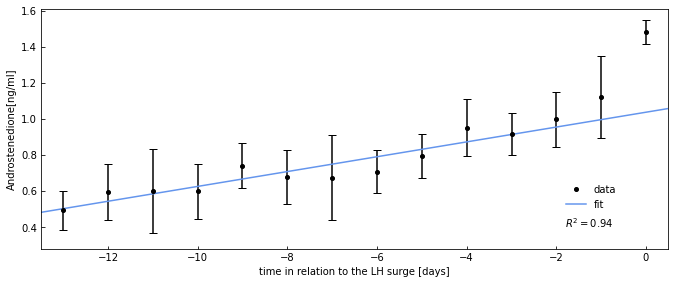

Regression line: y=0.041x+1.04
Standard error of the slope: 0.005


In [124]:
#load data
with open('Data/A_dex.csv') as file1: 
    A_dex = pd.read_csv(file1)
A_dex.A_errors=A_dex.A_errors-A_dex.A
A_dex['days']=np.arange(-13,15,1)

#linear regression
results = stats.linregress(A_dex['days'][:12], A_dex['A'][:12])
slope, intercept, r, p, se, ise = (results.slope, results.intercept, results.rvalue,results.pvalue,
                                   results.stderr, results.intercept_stderr)

#plot
plt.rcParams["figure.figsize"] = (1.5*2.5*3,1.5*2.5*1.18)
fit_line = slope*(np.arange(-17, 2, 1))+intercept
handle_fit, = plt.plot(np.arange(-17, 2, 1), (fit_line), color='cornflowerblue', label = 'fit')
handle_data, = plt.plot(A_dex['days'][:14], A_dex['A'][:14], 'ko', label='data', markersize=4)
plt.errorbar(A_dex['days'][:14], A_dex['A'][:14],
                             yerr = A_dex['A_errors'][:14], linestyle='None',
                                marker='None', capsize=4, capthick=1, color='black')

plt.xlim([-13.5, 0.5])
plt.text(-1.8, 0.4, f'$R^2={round(r, 3)}$')
plt.legend(handles=[handle_data, handle_fit], loc = [0.83,0.15], frameon=False)
plt.tick_params(direction='in')
plt.tick_params(direction='in', which='minor')
plt.ylabel('Androstenedione[ng/ml]')
plt.xlabel('time in relation to the LH surge [days]')
plt.show()
print(f'Regression line: y={round(slope, 3)}x+{round(intercept, 2)}')
print(f'Standard error of the slope: {round(se,3)}')



In [125]:
#calculating the fold change in Androstenedione
print(fit_line[-4]/fit_line[4]) 

1.9023768928578095


In [126]:
#calculating std of the factor
t1 = np.arange(-17, 2, 1)[4]
t2 = np.arange(-17, 2, 1)[-4]
delta_t = t2-t1
slope*delta_t*ise

0.017623682685816277

In [128]:
#calculating error of the factor
t1 = np.arange(-17, 2, 1)[4]
t2 = np.arange(-17, 2, 1)[-4]
delta_t = t2-t1
error=(delta_t/(fit_line[4])**2)*np.sqrt((intercept*se)**2+(slope*ise)**2)
print(error)

0.2246784931529183


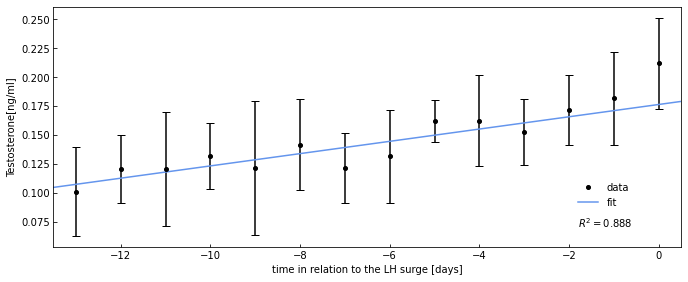

y=0.005x+0.176
0.001


In [145]:
#load data
with open('Data/T_dex.csv') as file1: 
    T_dex = pd.read_csv(file1)
T_dex.T_errors=T_dex.T_errors-T_dex['T']
T_dex['days']=np.arange(-13,14,1)

#plot
plt.rcParams["figure.figsize"] = (1.5*2.5*3,1.5*2.5*1.18)
results = stats.linregress(T_dex['days'][:12], T_dex['T'][:12])
slope, intercept, r, p, se, ise = (results.slope, results.intercept, results.rvalue,results.pvalue,
                                   results.stderr, results.intercept_stderr)

fit_line = slope*(np.arange(-17, 2, 1))+intercept
handle_fit, = plt.plot(np.arange(-17, 2, 1), (fit_line), color='cornflowerblue', label = 'fit')
handle_data, = plt.plot(T_dex['days'][:14], T_dex['T'][:14], 'ko', label='data', markersize=4)
plt.errorbar(T_dex['days'][:14], T_dex['T'][:14],
                             yerr = T_dex['T_errors'][:14], linestyle='None',
                                marker='None', capsize=4, capthick=1, color='black')

plt.xlim([-13.5, 0.5])
plt.text(-1.8, 0.07, f'$R^2={round(r, 3)}$')
plt.legend(handles=[handle_data, handle_fit], loc = [0.83,0.15], frameon=False)
plt.tick_params(direction='in')
plt.tick_params(direction='in', which='minor')
plt.ylabel('Testosterone[ng/ml]')
plt.xlabel('time in relation to the LH surge [days]')
plt.show()
print(f'y={round(slope, 3)}x+{round(intercept, 3)}')
print(round(se, 3))

In [131]:
#calculating the fold change in Testosterone
fit_line[-4]/fit_line[4]

1.5455697903457706

In [132]:
#calculating error of the factor
t1 = np.arange(-17, 2, 1)[4]
t2 = np.arange(-17, 2, 1)[-4]
delta_t = t2-t1
error=(delta_t/(fit_line[4])**2)*np.sqrt((intercept*se)**2+(slope*ise)**2)
print(error)

0.1511054410792572


### Granulosa cells numbers and Thecal mass for different follicular diameters
Adapted from Figure 2 in the paper :

>K. P. Mc Natty, [“Hormonal correlates of follicular development in the human ovary”](https://www.publish.csiro.au/bi/BI9810249), Australian Journal of Biological Sciences, vol. 34, no. 3, pp. 249–268, 1981, doi: 10.1071/BI9810249

Data was digitizeed from the image.

In [136]:
with open('Data/Granulosa_num_HC.csv') as file1: 
    granulosa_num_HC = pd.read_csv(file1)
with open('Data/Theca_mass_HC.csv') as file2: 
    theca_mass_HC = pd.read_csv(file2)

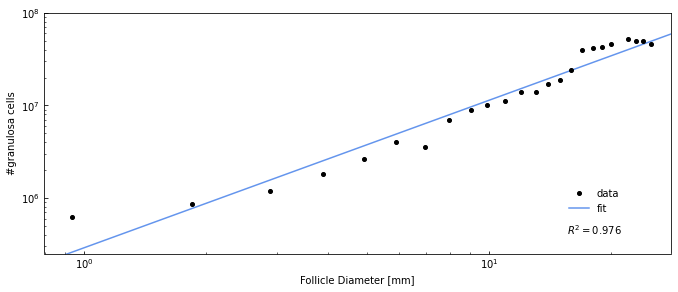

y=1.6x+12.6
slope=1.6x+-0.1


In [146]:
plt.rcParams["figure.figsize"] = (1.5*2.5*3,1.5*2.5*1.18)
slope, intercept, r, p, se = stats.linregress(np.log(granulosa_num_HC['Diameter']), np.log(granulosa_num_HC['Granulosa_num']*10**6))
fit_line = slope*np.log(np.arange(10**(-2), 10**2, 1))+intercept
handle_fit, = plt.plot(np.arange(10**(-2), 10**2, 1), np.exp(fit_line), color='cornflowerblue', label = 'fit')
handle_data, = plt.plot(granulosa_num_HC['Diameter'], granulosa_num_HC['Granulosa_num']*10**6, 'ko', label='data', markersize=4)
plt.xscale("log")
plt.yscale("log")

plt.xlim([10**(-0.1), 10**1.45])
plt.ylim([10**(5.4), 10**8])
plt.text(15.6, 10**5.6, f'$R^2={round(r, 3)}$')
plt.legend(handles=[handle_data, handle_fit], loc = [0.83,0.15], frameon=False)
plt.tick_params(direction='in')
plt.tick_params(direction='in', which='minor')
plt.xlabel('Follicle Diameter [mm]')
plt.ylabel('#granulosa cells')
plt.show()
print(f'y={round(slope, 1)}x+{round(intercept, 1)}')
print(f'slope={round(slope, 1)}x+-{round(se, 1)}')

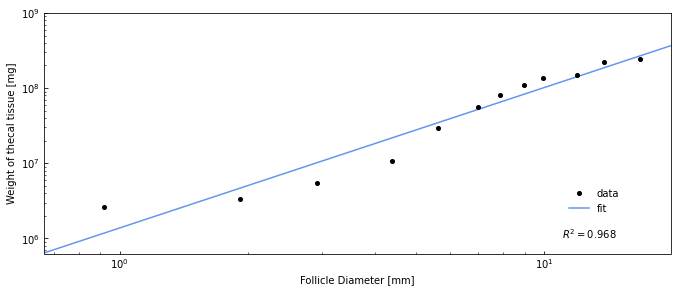

y=1.9x+14.1
slope=1.9x+-0.2


In [147]:
plt.rcParams["figure.figsize"] = (1.5*2.5*3,1.5*2.5*1.18)
slope, intercept, r, p, se = stats.linregress(np.log(theca_mass_HC['Diameter']), np.log(theca_mass_HC['Theca_mass']*10**6))
fit_line = slope*np.log(np.arange(10**(-2), 10**2, 1))+intercept
handle_fit, = plt.plot(np.arange(10**(-2), 10**2, 1), np.exp(fit_line), color='cornflowerblue', label = 'fit')
handle_data, = plt.plot(theca_mass_HC['Diameter'], theca_mass_HC['Theca_mass']*10**6, 'ko', label='data', markersize=4)
plt.xscale("log")
plt.yscale("log")

plt.xlim([10**(-0.18), 10**1.3])
plt.ylim([10**(5.8), 10**9])
plt.text(11, 10**6, f'$R^2={round(r, 3)}$')
plt.legend(handles=[handle_data, handle_fit], loc = [0.83,0.15], frameon=False)
plt.tick_params(direction='in')
plt.tick_params(direction='in', which='minor')
plt.xlabel('Follicle Diameter [mm]')
plt.ylabel('Weight of thecal tissue [mg]')


plt.show()
print(f'y={round(slope, 1)}x+{round(intercept, 1)}')
print(f'slope={round(slope, 1)}x+-{round(se, 1)}')